## **Machine Learning Project for Bank Credit Dataset**


The Bank Marketing Dataset in OpenML (https://www.openml.org/d/1461) is chosen for this project.
The selected dataset contains client data from a Portuguese bank's marketing campaign, aiming to predict whether a client will subscribe to a term deposit.

**Column Definitions:**


*   job:	Occupation
*   marital:	Marital status
*   education:	Education level
*   default:	Has credit in default? (yes/no)
*   balance:	Average yearly bank balance (in euros)
*   housing:	Has a housing loan? (yes/no)
*   loan:	Has a personal loan? (yes/no)
*   contact:	Contact communication type (cellular, telephone)
*   day:	Last contact day of the month
*   month:	Last contact month of the year
*   duration:	Duration of last contact in seconds
*   campaign:	Number of contacts during the current campaign
*   pdays: Days passed since last contact from a previous campaign (999 / -1 = no previous contact)
*  previous:	Number of contacts before this campaign
*  poutcome:	Outcome of the previous marketing campaign (success, failure, unknown)
*   target:	Has the client subscribed to a term deposit? (1 = no, 2 = yes)




### **Data Load Steps**

* OpenML Python API is used.
* Column names were renamed.
* The target variable was appended to the DataFrame.

In [51]:
# Import sklearn object
from sklearn.feature_selection import SelectFromModel,RFE
from sklearn.model_selection import train_test_split, cross_val_score, KFold,StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

In [28]:
!pip install openml
import openml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Access data with API Key
openml.config.apikey = 'd1d7d235b5af2860d5e4962ed225765e'

# Connect data
dataset = openml.datasets.get_dataset(1461)

# Construct dataframe
data_tuple = dataset.get_data(target=dataset.default_target_attribute)

X = data_tuple[0]
y = data_tuple[1]
df = X.copy()

# Rename the columns
df.columns = [
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
    'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
    'previous', 'poutcome'
]

df['target'] = y

# Check dataframe
print(df.head(5))

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no   2143.0     yes   no   
1   44    technician   single  secondary      no     29.0     yes   no   
2   33  entrepreneur  married  secondary      no      2.0     yes  yes   
3   47   blue-collar  married    unknown      no   1506.0     yes   no   
4   33       unknown   single    unknown      no      1.0      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome target  
0  unknown    5   may     261.0         1   -1.0       0.0  unknown      1  
1  unknown    5   may     151.0         1   -1.0       0.0  unknown      1  
2  unknown    5   may      76.0         1   -1.0       0.0  unknown      1  
3  unknown    5   may      92.0         1   -1.0       0.0  unknown      1  
4  unknown    5   may     198.0         1   -1.0       0.0  unknown      1  


In [29]:
# df is copied for future usage.
df_copy = df.copy()

### **Data Cleaning and Preprocessing**


* The dataset is checked for null and duplicated values.
* Categorical and numeric variables are determined.
* Ordinal encoding is used for categorical columns with ordinal order.
* For nominal categorical variables one-hot encoding is used.
* Target variable converted to binary values.


In [30]:
# Check for null and duplicates values
print(df.isnull().sum())
print(df.duplicated().sum())

# Check data statistics
print(df.describe())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
target       0
dtype: int64
0
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

         

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  uint8   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  float64 
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  uint8   
 10  month      45211 non-null  category
 11  duration   45211 non-null  float64 
 12  campaign   45211 non-null  uint8   
 13  pdays      45211 non-null  float64 
 14  previous   45211 non-null  float64 
 15  poutcome   45211 non-null  category
 16  target     45211 non-null  category
dtypes: category(10), float64(4), uint8(3)
memory usage: 1.9 MB


In [32]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
  print(col,":", df[col].unique())

job : ['management', 'technician', 'entrepreneur', 'blue-collar', 'unknown', ..., 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
Length: 12
Categories (12, object): ['admin.' < 'blue-collar' < 'entrepreneur' < 'housemaid' ... 'student' <
                          'technician' < 'unemployed' < 'unknown']
marital : ['married', 'single', 'divorced']
Categories (3, object): ['divorced' < 'married' < 'single']
education : ['tertiary', 'secondary', 'unknown', 'primary']
Categories (4, object): ['primary' < 'secondary' < 'tertiary' < 'unknown']
default : ['no', 'yes']
Categories (2, object): ['no' < 'yes']
housing : ['yes', 'no']
Categories (2, object): ['no' < 'yes']
loan : ['no', 'yes']
Categories (2, object): ['no' < 'yes']
contact : ['unknown', 'cellular', 'telephone']
Categories (3, object): ['cellular' < 'telephone' < 'unknown']
month : ['may', 'jun', 'jul', 'aug', 'oct', ..., 'jan', 'feb', 'mar', 'apr', 'sep']
Length: 12
Categories (12, object): ['apr' < 'aug' < 'de

In [33]:
# Make target column binary category values
df['target'] = df['target'].astype(str).str.strip()
df['target'] = df['target'].map({'1': 0, '2': 1})

df.target.unique()

array([0, 1])

In [34]:
# Converting pdays column into ordinal categories since it has mostly null values (later analysis has details on this issue)
print(df.pdays.isin([-1, 999]).sum())

def mapping_pdays(num):
    if num in [-1, 999]:
        return "no_contact"
    elif num <= 30:
        return "recent"
    elif num <= 90:
        return "1_3_months"
    else:
        return "over_3_months"

df['pdays_cat'] = df['pdays'].apply( mapping_pdays)
df = df.drop('pdays', axis=1)


# Filter ordinal categorical columns and determine order
ordinal_cols = ['education', 'month', 'poutcome','pdays_cat']
for x in ordinal_cols:
    df[x] = df[x].astype(str)
    df[x] = df[x].str.strip()

ordinal_order = [
    ['primary', 'secondary', 'tertiary', 'unknown'],
    ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
    ['failure', 'other', 'success', 'unknown'],
    ['no_contact', 'recent', '1_3_months', 'over_3_months']
]

# Apply ordinal encoding
encoder = OrdinalEncoder(categories=ordinal_order)
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])

# Converting non-numeric variables into numeric variables
nominal_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact']

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)


# Split features and target
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

36954


### **Data Distribution and Correlation Between Variables**



* Distribution in the target is checked. Since '0' values make up 88% of the whole dataset, StratifiedKFold is chosen to ensure the distribution in k-folds. However, this imbalance in target values can lead to bias and should be taken into account.
* The distribution of X variables in histograms indicates that some variables (housing, loan, default) are not evenly distributed.
* Features like balance, duration, and campaign are right-skewed with outliers.
* pdays_cat and poutcome have mostly null/no contact values.
* Overall, data is imbalanced, but results of this model should be carefully used, considering data quality, before implementing.
* Correlation between X variables and correlation between variables and target are also checked.
* Variables that have low correlation with the target (<|0.05|) indicate a weak relation, and 13 of 28 have it. In feature selection this variable is most likely to be eliminated.
* The only high correlation between X variables is between pdays_cat and poutcome. One of them will be eliminated in further feature selection methods.

In [35]:
# Check y value distribution
print(y.value_counts(normalize=True))

target
0    0.883015
1    0.116985
Name: proportion, dtype: float64


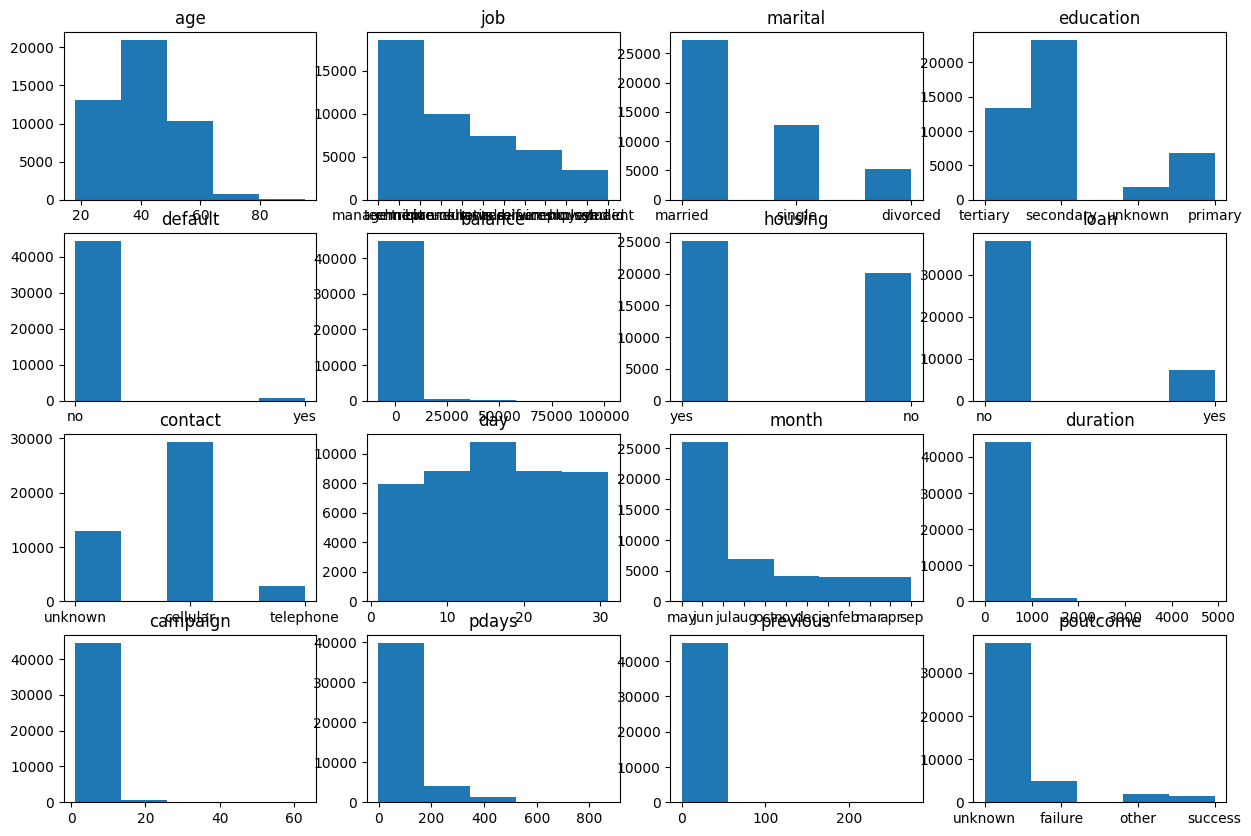

In [36]:
# Check x value distribution with original data set
import matplotlib.pyplot as plt

columns = df_copy.drop("target", axis=1).columns

fig,ax = plt.subplots(4,4, figsize=(15, 10))

for i in range(4):
  for j in range(4):
    ax[i,j].hist(df_copy[columns[i*4+j]],bins = 5 )
    ax[i, j].set_title(columns[i*4+j])

plt.show()

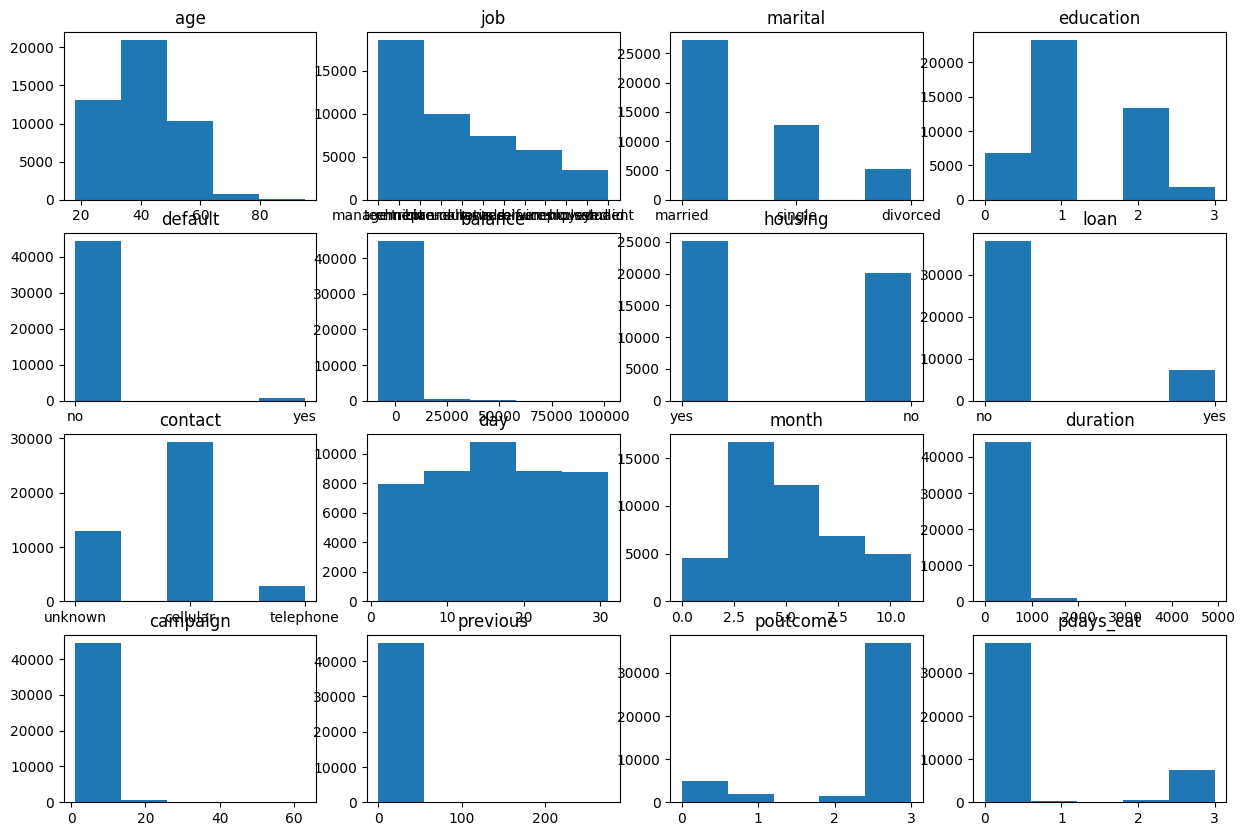

In [37]:
# Check x value distribution with processed dataset
import matplotlib.pyplot as plt

columns = df.drop("target", axis=1).columns

fig,ax = plt.subplots(4,4, figsize=(15, 10))

for i in range(4):
  for j in range(4):
    ax[i,j].hist(df[columns[i*4+j]],bins = 5 )
    ax[i, j].set_title(columns[i*4+j])

plt.show()

In [38]:
# Control correlation with y
corr = df_encoded.corr(numeric_only=True)['target'].sort_values(ascending=False)

print(corr)

target               1.000000
duration             0.394521
pdays_cat            0.161269
previous             0.093236
job_retired          0.079245
job_student          0.076897
education            0.066241
marital_single       0.063526
balance              0.052838
job_management       0.032919
age                  0.025155
job_unemployed       0.020390
month                0.018717
contact_telephone    0.014042
job_self-employed    0.000855
job_unknown          0.000267
job_technician      -0.008970
job_housemaid       -0.015195
job_entrepreneur    -0.019662
default_yes         -0.022419
job_services        -0.027864
day                 -0.028348
marital_married     -0.060260
loan_yes            -0.068185
job_blue-collar     -0.072083
campaign            -0.073172
poutcome            -0.077840
housing_yes         -0.139173
contact_unknown     -0.150935
Name: target, dtype: float64


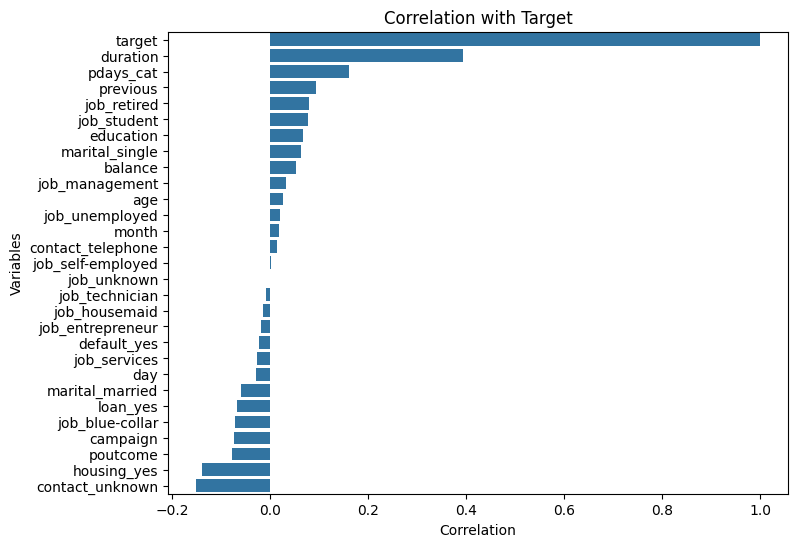

In [56]:
# Visualize correlation
plt.figure(figsize=(8,6))
sns.barplot(x=corr.values, y=corr.index)
plt.title('Correlation with Target')
plt.xlabel('Correlation')
plt.ylabel('Variables')
plt.show()

In [40]:
# Determine number of low correlated variables with target
print(X.shape)
low_corr_cols = corr[abs(corr) <= 0.05].index
X_low_corr = X.drop(low_corr_cols, axis=1)
print(X_low_corr.shape)

(45211, 28)
(45211, 15)


In [41]:
# Determine number of high correlated variables with target
print(X.shape)
high_corr_cols = corr[(abs(corr) >= 0.8) & (abs(corr) < 1)].index
X_high_corr = X.drop(high_corr_cols, axis=1)
print(X_high_corr.shape)

(45211, 28)
(45211, 28)


In [71]:
# Determine number of high correlated
corr_matrix = df_encoded.corr(numeric_only=True)
high_corr = []

for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        if i != j and abs(corr_matrix.loc[i, j]) > 0.8:
            high_corr.append((i, j))
print(high_corr)

[('poutcome', 'pdays_cat'), ('pdays_cat', 'poutcome')]


### **Feature Selection**



* Feature selection methods are used for improved model performance.
* Correlation, random forest, L1, and L2 were used. With the RFE technique, the best 10 features are selected.
* The common features of those models are selected for the model, keeping the model much simpler and more effective.
* pdays_cat was excluded; most likely its predictive power was already captured by poutcome.
* Variables like age and balance were eliminated due to weak correlation patterns.
* Duration remained since it has a strong positive correlation with the target, but it has a potential risk for data leakage since it is the length of the last contact in the current campaign.


In [43]:
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify=y)

In [60]:
# Correlation with target
corr_train = pd.concat([X_train, y_train.rename("target")], axis=1).corr(numeric_only=True)["target"].drop("target")
corr_selected_features = set(corr_train[abs(corr_train) >= 0.05].index)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=300, random_state=42)
random_forest.fit(X_train, y_train)
rf_selected_features = set(X_train.columns[random_forest.feature_importances_.argsort()[-10:]])

# L1 selection
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

l1_selected_features = set()
for c_val in [1, 0.1, 0.01]:
    l1 = LogisticRegression(penalty='l1', solver='liblinear', C=c_val,
                             max_iter=2000, random_state=42)
    l1.fit(X_train_scaled, y_train)
    selected = set(X_train.columns[l1.coef_[0] != 0])
    l1_selected_features.update(selected)

# L2 + RFE selection
l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=2000, random_state=42)
rfe = RFE(l2, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)
l2_selected_features = set(X_train.columns[rfe.support_])

# Common features
common_features = corr_selected_features & rf_selected_features & l1_selected_features & l2_selected_features

print("Correlation selected:", corr_selected_features)
print("Random Forest selected:", rf_selected_features)
print("L1 selected (all C tests):", l1_selected_features)
print("L2 selected:", l2_selected_features)
print("Common features:", common_features)

Correlation selected: {'housing_yes', 'job_student', 'education', 'marital_married', 'job_blue-collar', 'marital_single', 'contact_unknown', 'job_retired', 'pdays_cat', 'previous', 'campaign', 'balance', 'poutcome', 'duration', 'loan_yes'}
Random Forest selected: {'housing_yes', 'month', 'education', 'age', 'day', 'previous', 'campaign', 'balance', 'poutcome', 'duration'}
L1 selected (all C tests): {'housing_yes', 'campaign', 'job_unemployed', 'duration', 'job_housemaid', 'marital_single', 'day', 'job_retired', 'poutcome', 'contact_telephone', 'month', 'job_student', 'education', 'age', 'job_entrepreneur', 'job_services', 'contact_unknown', 'pdays_cat', 'job_management', 'default_yes', 'job_technician', 'job_unknown', 'job_self-employed', 'marital_married', 'job_blue-collar', 'previous', 'balance', 'loan_yes'}
L2 selected: {'housing_yes', 'education', 'marital_married', 'contact_unknown', 'job_retired', 'pdays_cat', 'campaign', 'poutcome', 'duration', 'loan_yes'}
Common features: {'hou

### **Model Selection**


* Since we have a classification problem, classification models are used, and their performance was evaluated using accuracy scores.
* XGBoostClassifier achieved the highest accuracy among all models.
* Models with five common features showed accuracy close to those using the full set (other Jupyter notebooks in this project have those models and scores); feature selection simplified the model without losing predictivity.
* The final model with the whole dataset has a confusion matrix with high false negatives. This indicates that the model has generally chosen '0' over '1'. The inequity in the target's distribution may have a result like that.
* When we compare scores among the models, XGBClassifier is the chosen model since it has the highest accuracy (0.8984) and the highest ROC-AUC score (0.9118).


In [61]:
# Remove eliminated features from X_train and X_test
X_train_selected = X_train[list(common_features)].copy()
X_test_selected  = X_test[list(common_features)].copy()


# Create the pipeline and cross validation object
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('Classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create alternative models to select best model
search_space = [
    {
        'Classifier': [LogisticRegression(solver='liblinear')],
        'Classifier__C': [0.01, 0.1, 1, 10],
        'Classifier__penalty': ['l1', 'l2']
    },
    {
        'Classifier': [KNeighborsClassifier()],
        'Classifier__n_neighbors': [3, 5, 7]
    },
    {
        'Classifier': [RandomForestClassifier(random_state=42)],
        'Classifier__n_estimators': [100, 300],
        'Classifier__max_depth': [3, 5, 7]
    },
    {
        'Classifier': [DecisionTreeClassifier(random_state=42)],
        'Classifier__max_depth': [3, 5, 7],
        'Classifier__criterion': ['gini', 'entropy']
    },
    {
        'Classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)],
        'Classifier__n_estimators': [50, 100],
        'Classifier__max_depth': [3, 5],
        'Classifier__learning_rate': [0.01, 0.1]
    }
]

In [62]:
# GridSearch Execution
grid = GridSearchCV(pipeline, search_space, cv=skf, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_selected, y_train)


print("Best Classifier:", grid.best_estimator_.named_steps['Classifier'].__class__.__name__)
print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best Classifier: XGBClassifier
Best Params: {'Classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'Classifier__learning_rate': 0.1, 'Classifier__max_depth': 3, 'Classifier__n_estimators': 50}
Best CV Accuracy: 0.900741119835167


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:41:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [65]:
# Append results in a dataframe
results = pd.DataFrame(grid.cv_results_)

# Create model_name
results['model_name'] = results['param_Classifier'].astype(str)

# Sort by test_score
best_models = results.sort_values(by='mean_test_score', ascending=False)

# Keep each model's best score
unique_models = best_models.drop_duplicates(subset='model_name', keep='first')

# Select Top 3 model
best_models = unique_models.head(3)

# Print Results
print("Top 3 models:")
top3 = best_models.reset_index(drop=True).head(3)
for i in range(len(top3)):
    model_name = top3.iloc[i]["model_name"]
    mean_acc   = round(top3.iloc[i]["mean_test_score"], 4)
    params     = top3.iloc[i]["params"]
    print(f"{i+1}. {model_name} | CV Accuracy: {mean_acc} | Params: {params}")

Top 3 models:
1. XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...) | CV Accuracy: 0.9007 | Params: {'Classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=Non

In [72]:
## Appliying best 3 result's paramaters to compare models
models = {
    "XGB (lr=0.1, depth=3, n=50)": XGBClassifier(
        learning_rate=0.1, max_depth=3, n_estimators=50,
        eval_metric="logloss", random_state=42
    ),
    "RandomForest (depth=7, n=100)": RandomForestClassifier(
        max_depth=7, n_estimators=100, random_state=42
    ),
    "DecisionTree (gini, depth=5)": DecisionTreeClassifier(
        criterion="gini", max_depth=5, random_state=42
    ),
}

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    y_prob = mdl.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name} , Acc: {acc:.4f} , ROC-AUC: {auc:.4f}")
    print(confusion_matrix(y_test, y_pred), "\n")

XGB (lr=0.1, depth=3, n=50) , Acc: 0.8984 , ROC-AUC: 0.9118
[[7841  144]
 [ 775  283]] 

RandomForest (depth=7, n=100) , Acc: 0.8953 , ROC-AUC: 0.9103
[[7945   40]
 [ 907  151]] 

DecisionTree (gini, depth=5) , Acc: 0.8986 , ROC-AUC: 0.8552
[[7784  201]
 [ 716  342]] 



In [67]:
# Test Accuracy of Best Model with x_test
xgb = XGBClassifier(
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=50,
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb)
])

pipeline.fit(X_train_selected, y_train)
test_score = pipeline.score(X_test_selected, y_test)

print("Final Test Accuracy:", round(test_score, 4))

Final Test Accuracy: 0.8995


In [73]:
selected = ['campaign', 'duration', 'education', 'housing_yes', 'poutcome']

#  final XGB pipeline
final_xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=50,
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', final_xgb)
])

# Fit the final model and conduct predictions
pipeline.fit(X[selected], y)
y_pred = pipeline.predict(X[selected])

# Final Metrics
cm = confusion_matrix(y, y_pred)
acc = accuracy_score(y, y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy:", round(acc, 4))

Confusion Matrix:
 [[39083   839]
 [ 3637  1652]]
Accuracy: 0.901


### **Conclusion**




* XGBClassifier is the chosen model since it has highest accuracy (0.8984) anh highest ROC-AUC score (0.9118).
* Most related features were: campaign, duration, education, housing_yes, and poutcome.
* In general, customers with a successful previous outcome (poutcome) and fewer contact attempts , and no housing loan are more likely to subscribe.